# 모듈 불러오기

In [4]:
import os 
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 시각화 함수

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string],'')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [7]:
DATA_IN_PATH ='./data_in/'
DATA_OUT_PATH ='./data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'


# 랜덤 시드 고정

In [9]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [12]:
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 모델 하이퍼파라미터 정의

In [15]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'word_embedding_dimension': 100,
         'conv_num_filters': 300,
         'conv_window_size': 3,
         'max_pool_seq_len': MAX_LEN,
         'sent_embedding_dimension': 128,
         'dropout_rate':0.2,
         'hidden_dimension': 200,
         'output_dimension': 1}

# 모델 선언 및 컴파일

In [32]:
# 문장 임베딩을 위한 커스텀 레이어 정의
class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()
        
        # 1D 합성곱 레이어 정의
        self.conv = layers.Conv1D(kargs['conv_num_filters'], 
                                  kargs['conv_window_size'], 
                                  activation=tf.keras.activations.relu, 
                                  padding='same')
        
        # 최대 풀링 레이어 정의
        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        
        # 밀집 레이어 정의
        self.dense = layers.Dense(kargs['sent_embedding_dimension'], 
                                  activation=tf.keras.activations.relu)

    def call(self, x):
        # 합성곱 레이어를 거친 결과
        x = self.conv(x)
        
        # 최대 풀링 레이어를 거친 결과
        x = self.max_pool(x)
        
        # 밀집 레이어를 거친 결과
        x = self.dense(x)
        
        # 마지막 차원을 제거하여 반환
        return tf.squeeze(x, 1)

In [33]:
# 문장 유사도 모델 정의
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        
        # 단어 임베딩 레이어 정의
        self.word_embedding = layers.Embedding(kargs['vocab_size'], 
                                               kargs['word_embedding_dimension'])
        
        # 문장 임베딩을 위한 인코더 정의 (Base와 Hypothesis), 두개의 문장의 유사도를 분석하기 위해 2개로 분리
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        
        # 밀집 레이어 정의
        self.dense = layers.Dense(kargs['hidden_dimension'], 
                                  activation=tf.keras.activations.relu)
        
        # 출력 레이어 정의 (시그모이드 활성화 함수 사용)
        self.logit = layers.Dense(1, activation=tf.keras.activations.sigmoid)
        
        # 드롭아웃 레이어 정의
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        # 입력을 두 개의 텐서로 분리 (Base와 Hypothesis)
        x1, x2 = x
        
        # 두 입력에 대해 임베딩을 수행
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)
        
        # 드롭아웃 적용
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        # 문장 임베딩 수행
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        # 두 문장을 결합 (Base와 Hypothesis)
        e_x = tf.concat([b_x, h_x], -1)
        
        # 결합된 벡터에 밀집 레이어 적용
        e_x = self.dense(e_x)
        
        # 드롭아웃 적용
        e_x = self.dropout(e_x)
        
        # 최종 출력 계산 (시그모이드 활성화)
        return self.logit(e_x)

In [34]:
model = SentenceSimilarityModel(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])


In [35]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out -- Folder already exists 



In [36]:
history = model.fit((q1_data, q2_data), labels , batch_size=BATCH_SIZE, epochs= NUM_EPOCHS, validation_split=VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6761 - loss: 0.5855
Epoch 1: val_accuracy improved from -inf to 0.70991, saving model to ./data_out/cnn_similarity.weights.h5
263/263 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.6763 - loss: 0.5853 - val_accuracy: 0.7099 - val_loss: 0.5597
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8028 - loss: 0.4205
Epoch 2: val_accuracy improved from 0.70991 to 0.78237, saving model to ./data_out/cnn_similarity.weights.h5
263/263 ━━━━━━━━━━━━━━━━━━━━ 67s 255ms/step - accuracy: 0.8028 - loss: 0.4204 - val_accuracy: 0.7824 - val_loss: 0.4920
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8865 - loss: 0.2649
Epoch 3: val_accuracy improved from 0.78237 to 0.79201, saving model to ./data_out/cnn_similarity.weights.h5
263/263 ━━━━━━━━━━━━━━━━━━━━ 62s 237ms/step - accuracy: 0.8866 - loss: 0.2648 - val_accuracy: 0.7920 - val_loss: 0.5930
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms

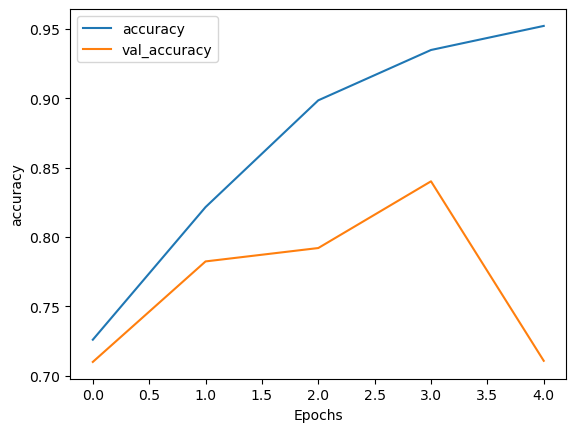

In [37]:
plot_graphs(history, 'accuracy')

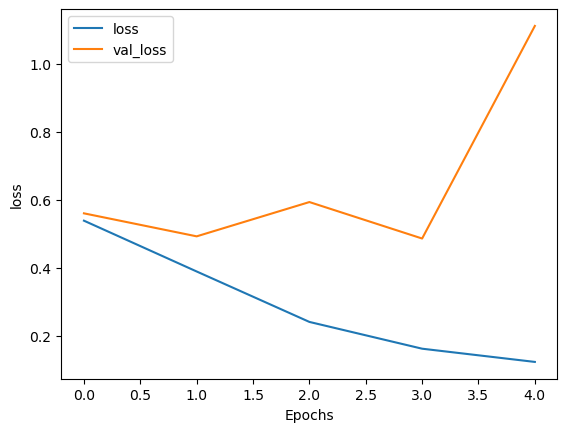

In [38]:
plot_graphs(history, 'loss')

# 데스트 데이터 불러오기

In [39]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

# 베스트 모델 불러오기

In [49]:
# SAVE_FILE_NM = 'cnn_similarity.weights.h5'
# model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

# 테스트 데이터 예측하기 

In [41]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 120s 52ms/step


In [43]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv("cnn_predict.csv", index=False, quoting=3)